# Ужасы линейной регрессии

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (
    HuberRegressor,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
np.random.seed(42)

# Разминка
## Упражнение 1

Вам дана таблица:

| x0 | x1 | x2 | y |
|----|----|----|---|
| 0  | 1  | 0  | 0 |
| 0  | 1  | 1  | 1 |
| 1  | 0  | 1  | 1 |
| 1  | 1  | 1  | 0 |
| 1  | 0  | 0  | 0 |
| 0  | 0  | 0  | 1 |

Как обучится модель линейной регрессии на таких данных? А если убрать/добавить признак? Поможет ли добавление новых данных?


In [5]:
values = np.array([
    [ 0  , 1  , 0 , 0 ],
    [ 0  , 1  , 1 , 1 ],
    [ 1  , 0  , 1 , 1 ],
    [ 1  , 1  , 1 , 0 ],
    [ 1  , 0  , 0 , 0 ],
    [ 0  , 0  , 0 , 1 ]
])
data = pd.DataFrame(columns=["x0", "x1", "x2", "y"], data=values)

test_values = np.array([
    [ 0  , 0 , 1 , 0 ],
    [ 1  , 1  , 0 , 1 ],
    [ 1  , 0  , 1 , 1 ],
    [ 1  , 1 , 1 , 0 ],
])

test_data = pd.DataFrame(columns=["x0", "x1", "x2", "y"], data=values)


In [16]:
model = LinearRegression().fit(data[["x0", "x1", "x2"]], data["y"])
(model.predict(data[["x0", "x1", "x2"]]) - data["y"]).sum()**2 / len(data["y"])

3.2869204384208823e-32

In [17]:
((model.predict(test_data[["x0", "x1", "x2"]]) - test_data["y"])**2).sum() / len(test_data["y"])

8.217301096052207e-32

# Упражнение 2
Рассмотрим двумерное нормальное распределение.

In [18]:
data = pd.DataFrame(columns=["x", "y"])
data["x"] = np.random.normal(0, 10, 100)
data["y"] = data["x"] * 0.1 + np.random.normal(5, 30, 100)


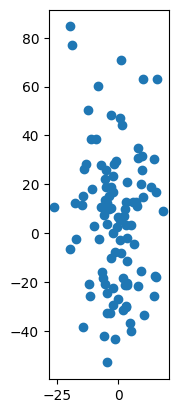

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data["x"],data["y"])
ax.set_aspect('equal')

Нам необходимо построить модель линейной регрессии для этих данных.Поэкспериментируйте, пока не получится.

In [20]:
model = LinearRegression()
model.fit(np.array(data.loc[:, "x"]).reshape(-1, 1), data["y"])

LinearRegression()

In [21]:
preds = model.predict(np.array(data.loc[:, "x"]).reshape(-1, 1))

<Axes: xlabel='x', ylabel='y'>

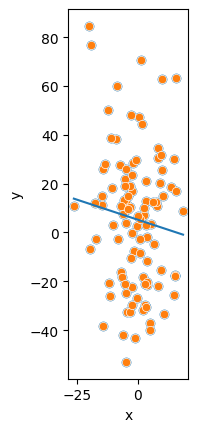

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data["x"],data["y"])
ax.set_aspect('equal')
sns.scatterplot(ax=ax, x=data["x"], y=data["y"])
sns.lineplot(ax=ax, x=data["x"], y=preds)

<Axes: xlabel='x', ylabel='y'>

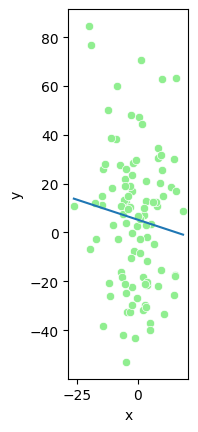

In [24]:
scaler = StandardScaler()
data_norm = scaler.fit_transform(np.array(data["x"]).reshape(-1, 1), y=data["y"])
model = LinearRegression()
model.fit(np.array(data_norm).reshape(-1, 1), data["y"])
preds = model.predict(data_norm)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
sns.scatterplot(ax=ax, x=data["x"], y=data["y"], color="lightgreen")
sns.lineplot(ax=ax, x=data["x"], y=preds)

# Положения линейной регрессии
**Линейность**: взаимосвязь между зависимыми и независимыми переменными линейна.

**Независимость**: Наблюдения независимы друг от друга.

**Гомоскедастичность**: дисперсия ошибок постоянна на всех уровнях независимых переменных.

**Нормальность**: ошибки подчиняются нормальному распределению.

**Нет мультиколлинеарности**: независимые переменные не сильно коррелируют друг с другом.

**Нет эндогенности**: между ошибками и независимыми переменными нет связи.

## Ловушки в данных

Рассмотрим набор данных, состоящий из 2 разных предикторов и четырех таргетов. Построим 4 разные модели по парам (x123, y1), (x123, y2),(x123, y3), (x4, y4).

In [26]:
data_path = "D:\data\machine_learning"

In [27]:
quartet_df = pd.read_csv(f"{data_path}/Anscombe_quartet_data.csv")

Для начала рассмотрим значения корреляций между признаками и таргетами

In [28]:
def corrplot(d: pd.DataFrame) -> None:
  corr = d.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  figsize = (min(d.shape[1], 11), min(d.shape[1], 9))
  f, ax = plt.subplots(figsize=figsize)
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

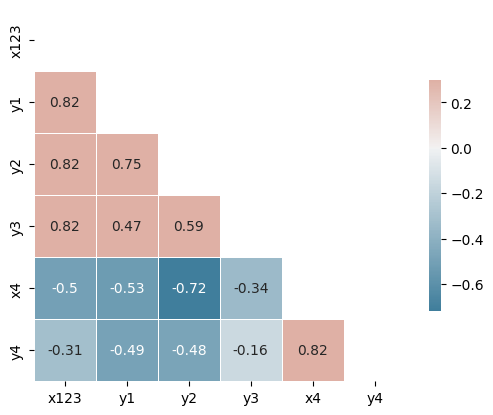

In [29]:
corrplot(quartet_df)

Как видно, корреляции одинаковы. Однако, если построить модели и графики предсказаний, результаты будут знгачительно отличаться.
ЭТакже выведем значения коэффициентов модели.

In [30]:
# Anscombe 1
x = np.array(quartet_df['x123']).reshape((-1, 1))
y = np.array(quartet_df['y1'])
model_1 = LinearRegression().fit(x, y)
y_pred = model_1.predict(x)
r_sq = model_1.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_1.intercept_}")
print(f"slope: {model_1.coef_}")


coefficient of determination: 0.6665424595087748
intercept: 3.0000909090909094
slope: [0.50009091]


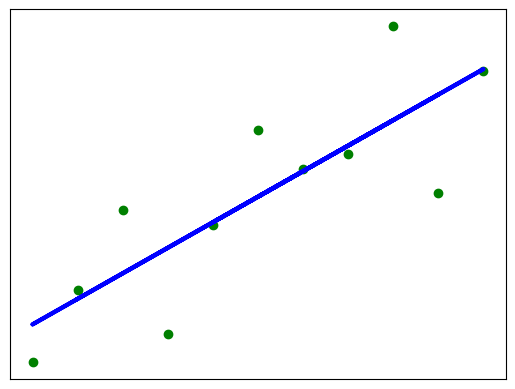

In [31]:
plt.scatter(x, y, color="green")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [32]:
# Anscombe 2
x=np.array(quartet_df['x123']).reshape((-1, 1))
y=np.array(quartet_df['y2'])
model_2 = LinearRegression().fit(x, y)
y_pred = model_2.predict(x)
r_sq = model_2.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_2.intercept_}")
print(f"slope: {model_2.coef_}")

coefficient of determination: 0.6662420337274844
intercept: 3.00090909090909
slope: [0.5]


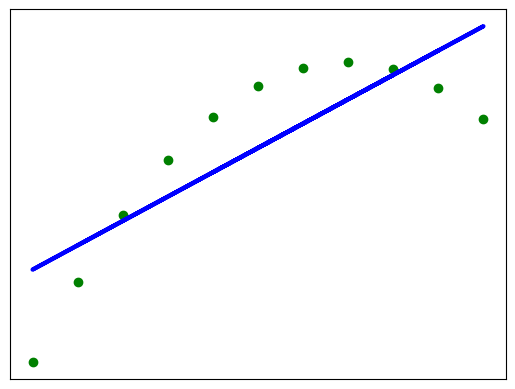

In [33]:
plt.scatter(x, y, color="green")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [34]:
# Anscombe 3
x=np.array(quartet_df['x123']).reshape((-1, 1))
y=np.array(quartet_df['y3'])
model_3 = LinearRegression().fit(x, y)
y_pred = model_3.predict(x)
r_sq = model_3.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_3.intercept_}")
print(f"slope: {model_3.coef_}")

coefficient of determination: 0.6663240410665592
intercept: 3.002454545454545
slope: [0.49972727]


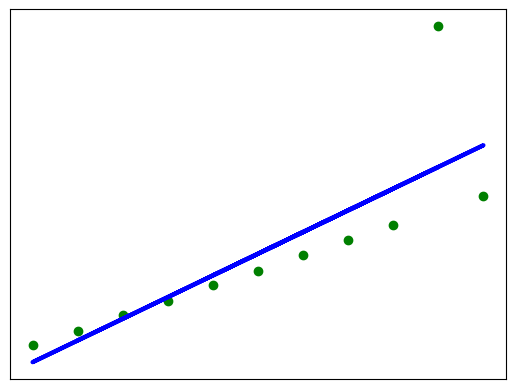

In [35]:
plt.scatter(x, y, color="green")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [36]:
# Anscombe 4
x=np.array(quartet_df['x4']).reshape((-1, 1))
y=np.array(quartet_df['y4'])
model_4 = LinearRegression().fit(x, y)
y_pred = model_4.predict(x)
r_sq = model_4.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_4.intercept_}")
print(f"slope: {model_4.coef_}")

coefficient of determination: 0.6667072568984653
intercept: 3.0017272727272726
slope: [0.49990909]


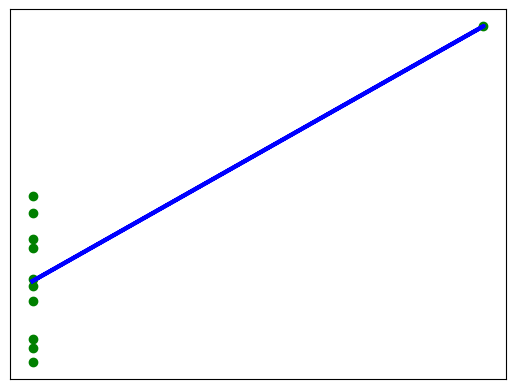

In [37]:
plt.scatter(x, y, color="green")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

Как видно, все эти зависимости имеют разную природу, но при этом порождают модели с практически одинаковыми параметрами. Таким образом, чрезвычайно важно проводить достаточно объемный EDA.
Датасте же - известный набор [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet), который показывает как важнность графического представления данных, так и эффект от выбросов и нелинейной связи

## Гетероскедастичность

Рассмотрим данные о стоимости домовладения. При этом будем использовать следующие признаки:
* Y = стоимость дома
* X1 = площадь дома
* X2 = площадь участка

In [43]:
data = pd.read_csv(f"{data_path}/realestate.txt", sep="\t")

In [53]:
data = data[["SalePrice", "SqFeet", "Lot"]]

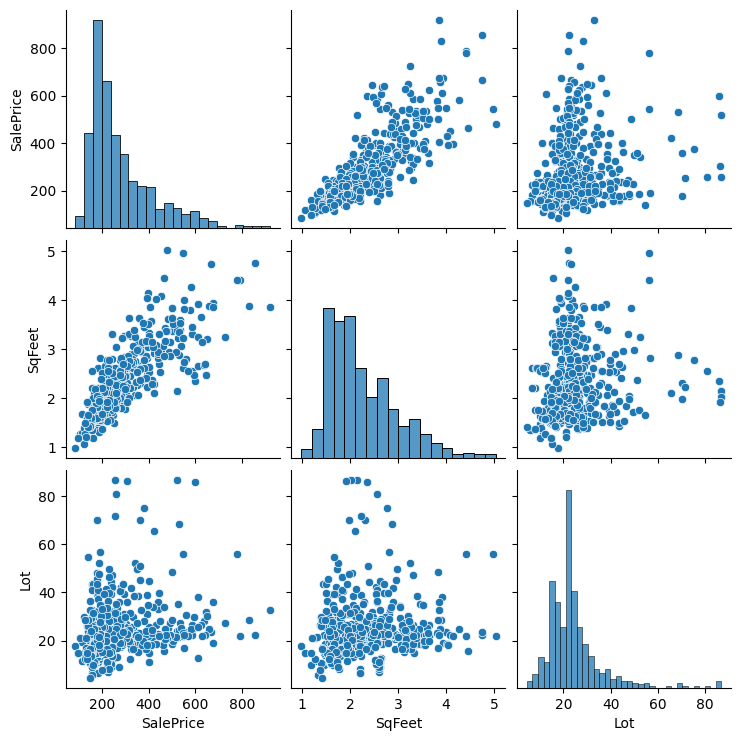

In [54]:
sns.pairplot(data)

In [55]:
data = np.log(data)

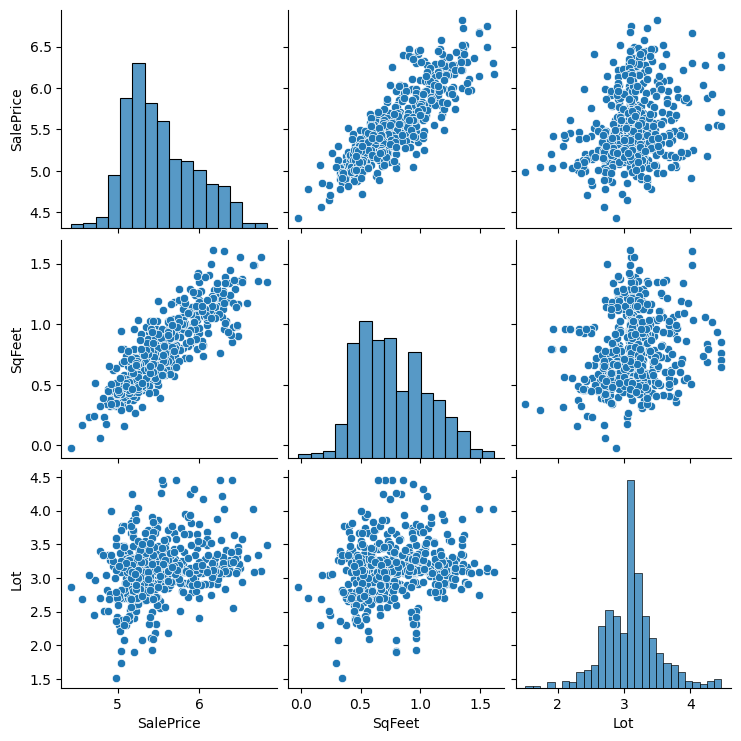

In [56]:
sns.pairplot(data)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(data[["SqFeet", "Lot"]], data["SalePrice"])


Поскольку все переменные сильно асимметричны, мы сначала логарифмизируем каждую переменную. Затем, если провести регрессионный анализ и оценить график остатков в сравнении с предсказанными значениями, можно отметить несколько «коническую» форму остатков.

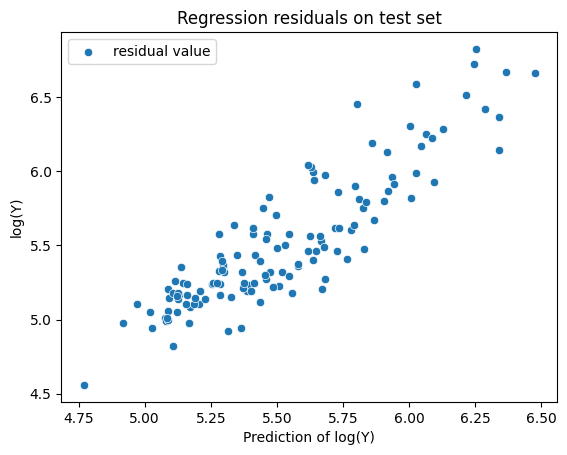

In [58]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
sns.scatterplot(x=preds, y=y_test, label="residual value")
plt.xlabel('Prediction of log(Y)')
plt.ylabel('log(Y)')
plt.legend()
plt.title(f'Regression residuals on test set')
plt.show()

In [59]:
print(f"The score of prediction is: {model.score(X_test, y_test)}")

The score of prediction is: 0.7801857108941898


Другой способ построить график остатков предлагает Sklearn

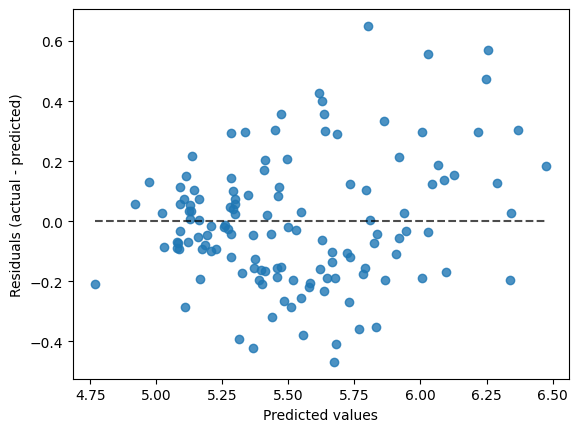

In [60]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=y_test, y_pred=preds)
display.plot()
plt.show()

Линейная модель описывается уравнением \begin{equation*} \textbf{Y}=\textbf{X}\beta+\epsilon^{*}, \end{equation*}
При этом $ \epsilon^{*} $ распределены нормально с нулевым средним и изменяющейся дисперсией:
\begin{equation*} \left(\begin{array}{cccc} \sigma^{2}_{1} & 0 & \ldots & 0 \\ 0 & \sigma^{2}_{2} & \ldots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \sigma^{2}_{n} \\ \end{array} \right) \end{equation*}
Тогда мы можем определить веса $ w_i = 1/\sigma^{2}_{i} $ так чтобы
\begin{equation*}\textbf{W}=\left( \begin{array}{cccc} w_{1} & 0 & \ldots & 0 \\ 0& w_{2} & \ldots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0& 0 & \ldots & w_{n} \\ \end{array} \right) \end{equation*}


Поскольку каждый вес обратно пропорционален дисперсии ошибки, он отражает информацию, содержащуюся в этом наблюдении. Итак, наблюдение с небольшой дисперсией ошибки имеет большой вес, поскольку оно содержит относительно больше информации, чем наблюдение с большой дисперсией ошибки (малый вес).
Веса должны быть известны (или, чаще всего, оценены) с точностью до константы пропорциональности.

Тогда можно поставить задачу взвешенной регрессиии \begin{equation*} \sum_{i=1}^n w_i^2(y_i - (\alpha 1 + \beta x_i))^2 = \sum_{i=1}^n (w_i y_i - (\alpha w_i + \beta w_i x_i))^2
\end{equation*}


Так как остатки в нашей задаче зависят от величины признака X, мы можем предсказать их по этому признаку.

In [62]:
add_x_train = model.predict(X_train)
add_x_test = model.predict(X_test)
# log is used to force all estimates to be positive
add_y_train = np.sqrt(np.abs(model.predict(X_train) - y_train))
add_y_test = np.sqrt(np.abs(model.predict(X_test) - y_test))


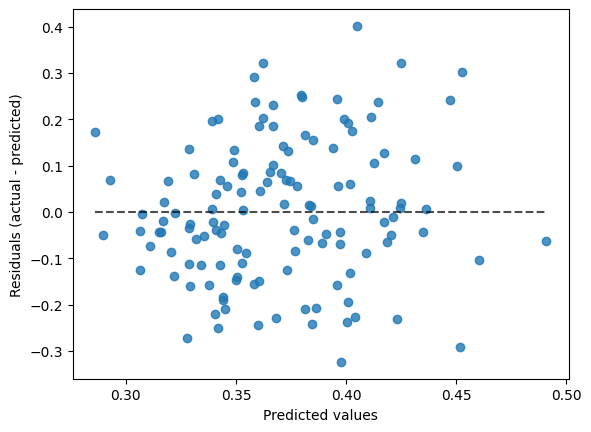

In [63]:
weight_regressor = LinearRegression().fit(X_train, add_y_train)
residual_estimates_train = weight_regressor.predict(X_train)
residual_estimates_test = weight_regressor.predict(X_test)
display = PredictionErrorDisplay(y_true=add_y_test, y_pred=residual_estimates_test)
display.plot()
plt.show()

In [64]:
weights_train = 1 / ((residual_estimates_train))
weights_test = 1 / ((residual_estimates_test))

# weights_train = (np.max(np.abs(add_y_train)) - np.abs(add_y_train))**2
# weights_test = (np.max(np.abs(add_y_test)) - np.abs(add_y_test))**2


In [65]:
updated_model = LinearRegression().fit(X_train, y_train, weights_train)
updated_preds = updated_model.predict(X_test)

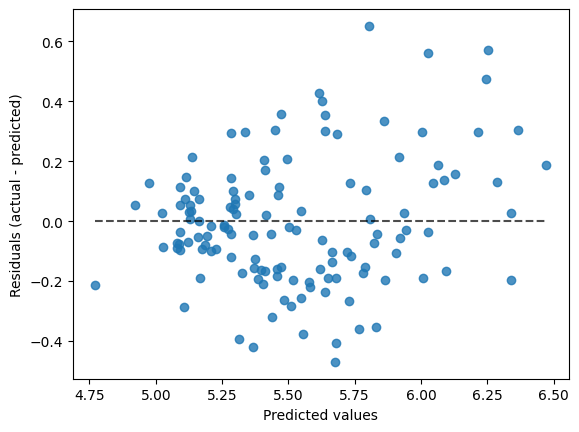

In [66]:
display = PredictionErrorDisplay(
    y_true=y_test, y_pred = updated_preds
    )
display.plot()
plt.show()

In [67]:
print(f"The score of prediction is: {updated_model.score(X_test, y_test, weights_test)}")

The score of prediction is: 0.7774191415986773


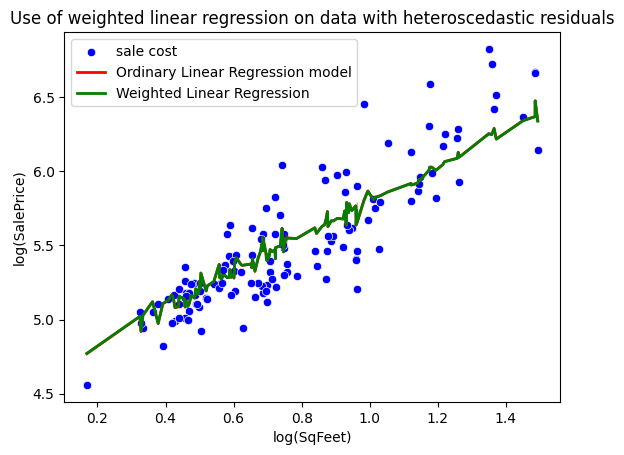

In [68]:
sns.scatterplot(x=X_test["SqFeet"], y=y_test, label='sale cost', color='blue')
sns.lineplot(x=X_test["SqFeet"], y=preds, label='Ordinary Linear Regression model', color='red', linewidth=2)
sns.lineplot(x=X_test["SqFeet"], y=updated_preds, label='Weighted Linear Regression', color='green', linewidth=2)
plt.xlabel('log(SqFeet)')
plt.ylabel('log(SalePrice)')
plt.legend()
plt.title(f'Use of weighted linear regression on data with heteroscedastic residuals')
plt.show()

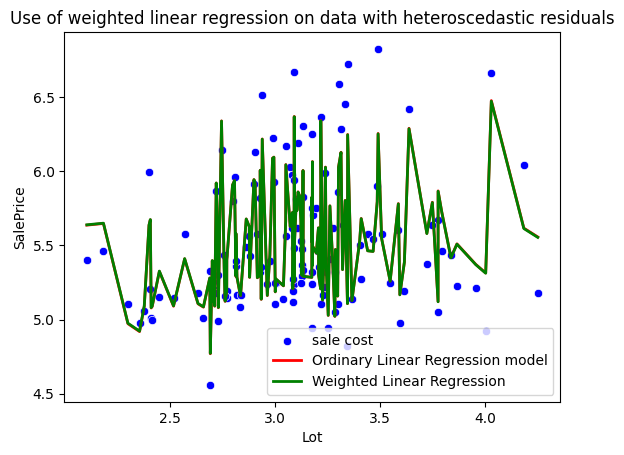

In [69]:
sns.scatterplot(x=X_test["Lot"], y=y_test, label='sale cost', color='blue')
sns.lineplot(x=X_test["Lot"], y=preds, label='Ordinary Linear Regression model', color='red', linewidth=2)
sns.lineplot(x=X_test["Lot"], y=updated_preds, label='Weighted Linear Regression', color='green', linewidth=2)
plt.xlabel('Lot')
plt.ylabel('SalePrice')
plt.legend()
plt.title(f'Use of weighted linear regression on data with heteroscedastic residuals')
plt.show()

## Полиномиальная регрессия

Рассмотрим набор данных Bluegills
В 1981 году n = 78 [cинежаберных солнечников](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%BD%D0%B5%D0%B6%D0%B0%D0%B1%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D1%81%D0%BE%D0%BB%D0%BD%D0%B5%D1%87%D0%BD%D0%B8%D0%BA) были случайным образом отобраны из озера Мэри в Миннесоте (Кук и Вайсберг, 1999):
* Длина (в мм) рыбы
* Возраст (в годах) рыбы


In [70]:
df = pd.read_csv(f"{data_path}/bluegills.txt", sep="\t")

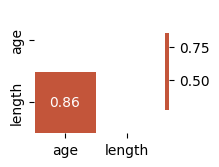

In [71]:
corrplot(df)

<Axes: xlabel='age', ylabel='length'>

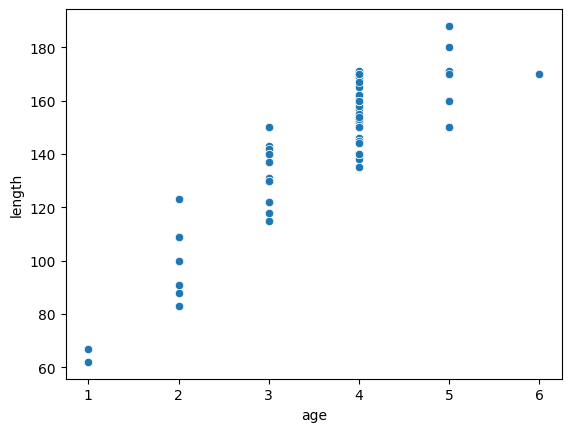

In [73]:
sns.scatterplot(df, x="age", y="length")

График позволяет предположить, что в данных наблюдается положительная динамика. Неудивительно, что с увеличением возраста рыб их длина имеет тенденцию к увеличению. Однако эта тенденция не выглядит вполне линейной. Кажется, что отношения слегка искривлены.

Один из способов моделирования кривизны этих данных — сформулировать «полиномиальную модель второго порядка»:

$ Y=\beta_0+ \sum_i (\alpha_i  X_i^2) + \sum_i (\beta_i  X_i) + \sum_{j \neq i} (\gamma_{ij}  X_i X_j) + \epsilon $

Сделать это просто, введя в данные полиномиальные признаки (PolynomialFeatures) и обучив обычную линейную модель.

In [75]:
X = np.array(df["age"]).reshape(-1, 1)
y =np.array(df["length"])
model_basic = LinearRegression()
model_basic.fit(X, df["length"])
y_basic = model_basic.predict(X)

In [78]:
degree = 2  # Set the polynomial degree
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X=np.array(df.loc[:,"age"]).reshape(-1, 1))
X = np.array(df["age"]).reshape(-1, 1)
y =np.array(df["length"])
model_basic = LinearRegression()
model_basic.fit(X, df["length"])
model_poly = LinearRegression()
model_poly.fit(X_poly,  df["length"])
y_basic = model_basic.predict(X)
y_poly = model_poly.predict(X_poly)

In [80]:
print(f"coefficient of determination of linear model: {model_basic.score(X, y)}")
print(f"coefficient of determination of polynomial model: {model_poly.score(X_poly, y)}")

coefficient of determination of linear model: 0.7348821471782518
coefficient of determination of polynomial model: 0.8011378030846004


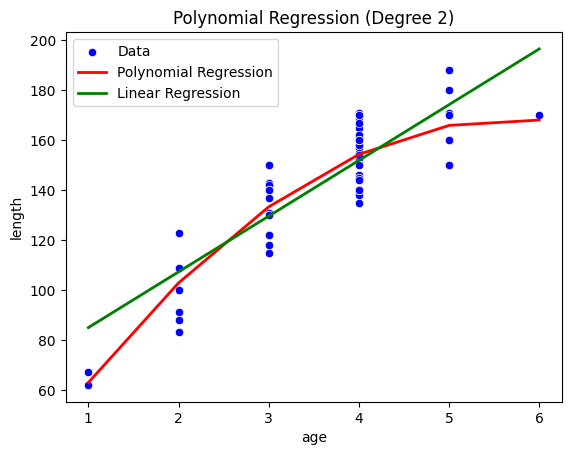

In [82]:
sns.scatterplot(df,x="age", y="length", label='Data', color='blue')
sns.lineplot(x=df["age"], y=y_poly, label='Polynomial Regression', color='red', linewidth=2)
sns.lineplot(x=df["age"], y=y_basic, label='Linear Regression', color='green', linewidth=2)
plt.xlabel('age')
plt.ylabel('length')
plt.legend()
plt.title(f'Polynomial Regression (Degree {degree})')
plt.show()

In [83]:
degree = 2  # Set the polynomial degree
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X=np.array(df.loc[:,"age"]).reshape(-1, 1))
X = np.array(df["age"]).reshape(-1, 1)
y =np.array(df["length"])
model_basic = LinearRegression()
model_basic.fit(X, df["length"])
model_poly = LinearRegression()
model_poly.fit(X_poly,  df["length"])
y_basic = model_basic.predict(X)
y_poly = model_poly.predict(X_poly)

## Выбросы
Как мы уже видели, выбросы могут сильно влиять на предсказания линейной модели. Даже один выброс может нарушить одно из условий линейной регрессии. К счастью, существует много сапособов с ними бороться.
Простейший вариант - использовать не MSE, а MAE. Почему?

Однако есть и более сложные варианты. Например, комбинация MSE и MAE дает **HuberLoss**.

Другой робастный вариант - **Theil-Sen regression**. Этот метод строит медиану наклона модели между всеми парами наблюдений. Проблема этого метода в том, что для больших наборов данных вычислительная сложность метода становится слишком большой.

Третий метод: **RANSAC**. В этом методе итеративно берутся подвыборки заданного размера, строятся модели и считаются расстояния от предсказания до реальной точки. Далее точки, для которых расстояние меньше некоторой границы, считаются доверенными. На этих данных обучается новая модель-кандидат. В качестве финальной используется лучший кандидат. Однако данный метод подходит только для моделей, которые не требуют очень большого количества данных.

Рассмотрим синтетические данные. Пусть это будут синусоидальные данные, но некоторые наблюдения будут "испорчены"

In [84]:
X = np.random.normal(size=400)
y = np.sin(X)
# Make sure that it X is 2D
X = X.reshape(-1,1)

X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test.reshape(-1,1)

y_errors = y.copy()
y_errors[::3] = 3

X_errors = X.copy()
X_errors[::3] = 3

y_errors_large = y.copy()
y_errors_large[::3] = 10

X_errors_large = X.copy()
X_errors_large[::3] = 10

C:\Users\a00628123\AppData\Local\Temp\ipykernel_1916\3750125068.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  errors_df = pd.concat([errors_df,pd.DataFrame.from_dict(data=errors_dict) ])


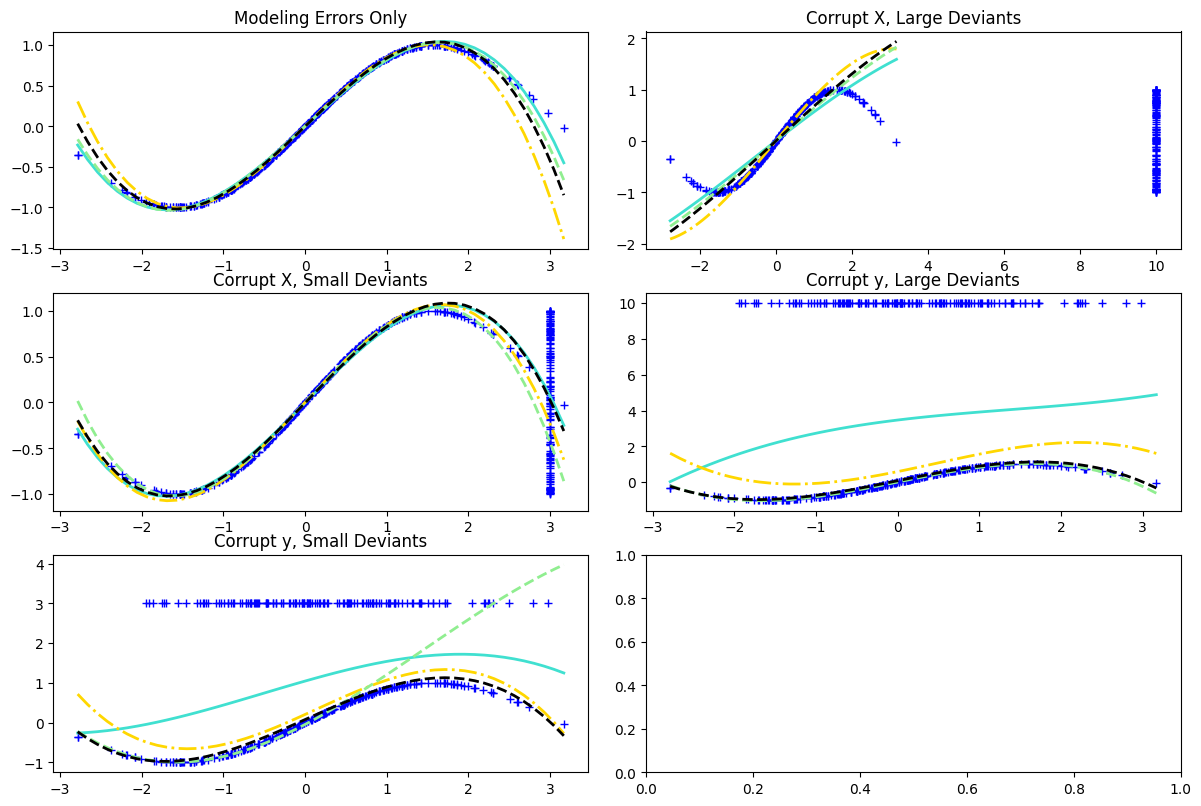

In [85]:
estimators = {
    "OLS": LinearRegression(),
    "Theil-Sen": TheilSenRegressor(random_state=42),
    "RANSAC": RANSACRegressor(random_state=42),
    "Huber": HuberRegressor(),
}

colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "Huber": "black",
}
linestyle = {"OLS": "-", "Theil-Sen": "-.", "RANSAC": "--", "Huber": "--"}
lw = 2
fig, ax = plt.subplots(nrows=3, ncols=2, figsize= (12,8))
fig.tight_layout()
x_plot = np.linspace(X.min(), X.max())

errors_df = pd.DataFrame(columns = list(estimators.keys()))

for i, (title, this_X, this_y) in enumerate([
    ("Modeling Errors Only", X, y),
    ("Corrupt X, Small Deviants", X_errors, y),
    ("Corrupt y, Small Deviants", X, y_errors),
    ("Corrupt X, Large Deviants", X_errors_large, y),
    ("Corrupt y, Large Deviants", X, y_errors_large),
]):
    ax[i % 3, i // 3].plot(this_X[:, 0], this_y, "b+")
    errors_dict = {"Problem": title}

    for name, estimator in estimators.items():
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        errors_dict[name] = [mse]
        y_plot = model.predict(x_plot[:, np.newaxis])
        ax[i % 3, i // 3].plot(
            x_plot,
            y_plot,
            color=colors[name],
            linestyle=linestyle[name],
            linewidth=lw,
            label="%s: error = %.3f" % (name, mse),
        )
    errors_df = pd.concat([errors_df,pd.DataFrame.from_dict(data=errors_dict) ])
    ax[i % 3, i // 3].title.set_text(title)
plt.show()

In [ ]:
colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "Huber": "black",
}

In [86]:
errors_df

,OLS,Theil-Sen,RANSAC,Huber,Problem
0,0.001694,0.011386,0.002157,0.003481,Modeling Errors Only
0,0.002127,0.002502,0.003509,0.002170,"Corrupt X, Small Deviants"
0,1.015138,0.075340,0.412435,0.008279,"Corrupt y, Small Deviants"
0,0.062297,0.084876,0.062293,0.066616,"Corrupt X, Large Deviants"
0,11.242579,0.648703,0.001992,0.008278,"Corrupt y, Large Deviants"


## Мультиколлинеарность

Мультиколлинеарность представляет собой проблему, поскольку она дает менее надежные результаты регрессионной модели. Это связано с более широкими доверительными интервалами (большими стандартными ошибками), которые могут снизить статистическую значимость коэффициентов регрессии. При анализе данных это может привести к ложным впечатлениям.

Рассмотрим уже знакомый нам набор данных, посвященный недвижимости.

In [88]:
data = pd.read_csv(f"{data_path}/realestate.txt", sep="\t")

In [89]:
data["SalePrice"] = np.log(data["SalePrice"])
data.describe()

,SalePrice,SqFeet,Beds,Baths,Air,Garage,Pool,Year,Quality,Style,Lot,Highway
count,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000
mean,5.525443,2.260879,3.477927,2.646833,0.831094,2.097889,0.069098,1966.856046,2.186180,3.349328,24.344668,0.021113
std,0.430851,0.711726,1.003835,1.058861,0.375029,0.653405,0.253864,17.620476,0.639923,2.563209,11.681280,0.143900
min,4.430817,0.980000,1.000000,1.000000,0.000000,0.000000,0.000000,1885.000000,1.000000,1.000000,4.560000,0.000000
25%,5.192957,1.701000,3.000000,2.000000,1.000000,2.000000,0.000000,1956.000000,2.000000,1.000000,17.159000,0.000000
50%,5.437644,2.061000,3.000000,3.000000,1.000000,2.000000,0.000000,1966.000000,2.000000,2.000000,22.196000,0.000000
75%,5.814131,2.638000,4.000000,3.000000,1.000000,2.000000,0.000000,1981.000000,3.000000,7.000000,26.777000,0.000000
max,6.824374,5.032000,7.000000,7.000000,1.000000,7.000000,1.000000,1998.000000,3.000000,11.000000,86.830000,1.000000


Обучим базовую модель на одном признаке.

In [90]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.696237587585443
Coefficients are: [0.50970481]


Теперь добавим несколько видов мультиколлинеарности в данных.

# Perfect multicollinearity

Если две или более независимых переменных имеют между собой линейную связь, то
у нас получается идеальная мультиколлинеарность.
Примеры: включение одной и той же информации дважды (стоимость в рублях и долларах), неправильное использование фиктивных переменных (dummy variables trap) и т. д.
Вот пример идеальной мультиколлинеарности в модели с двумя объясняющими
переменными:
\begin{equation}
y = α_{1} X_1 + \alpha_{2} X_2
\end{equation}
\begin{equation}
X_1 = \beta_1 X_2 + \beta_2
\end{equation}


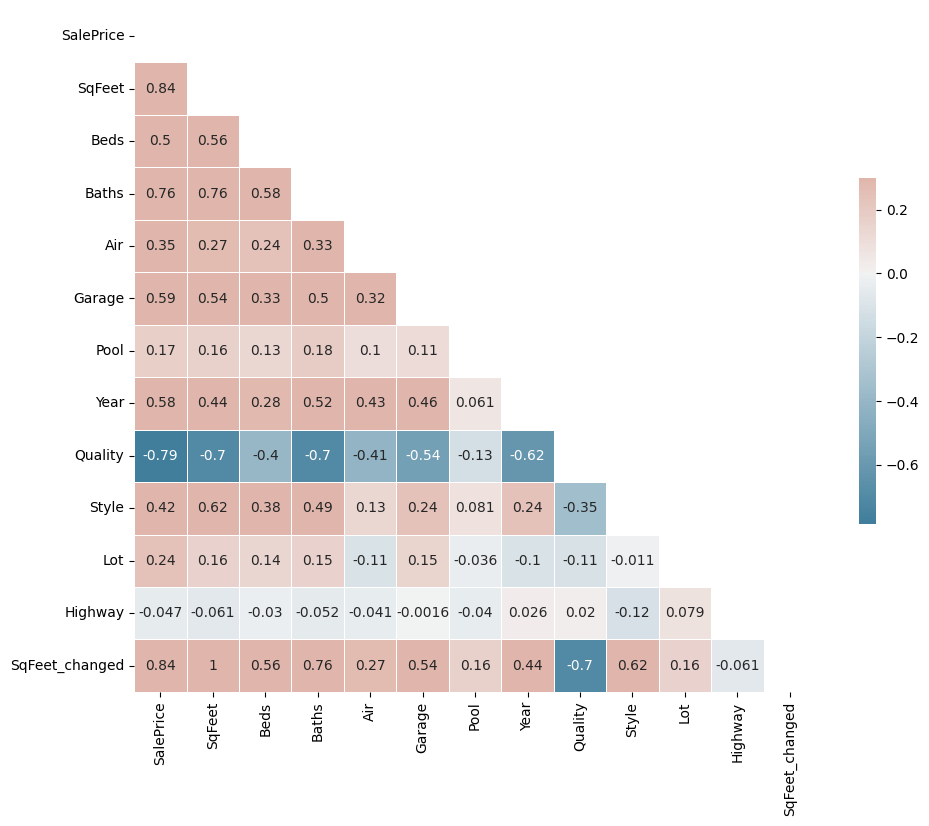

In [91]:
data["SqFeet_changed"] = data["SqFeet"]* 0.8 + 10
corrplot(data)

In [92]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.6976044010501041
Coefficients are: [-2.10422524e+13  1.68338019e+13]


In [94]:
data["SqFeet_changed_2"] = data["SqFeet"]* 0.5 - 10
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet_changed_2", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.6955616974021777
Coefficients are: [-2.10409587e+13  3.09650036e+10  1.68172844e+13]


В принципе, совершенная коллинеарность не дает в принципе построить линейную модель, так как невозможно оценить маржинальный эффект воздействия признака на целевую переменную, сохраняя остальные константными.
)
На практике же, даже если конкретная реализация OLS позволит построить коэффициенты, это ведет к тому, что модель перестает быть устойчивой.

### Несовершенная мультиколлинеарность
Несовершенная мультиколлинеарность не нарушает базовых предположений ЛР. Следовательно, теорема Гаусса-Маркова говорит нам, что оценки МНК состоятельны.

Так почему же нас волнует мультиколлинеарность?
2. Дисперсия и стандартные ошибки оценок коэффициентов регрессии будут
увеличиваться. Это означает более низкую t-статистику.
3. На общую точность уравнения регрессии мультиколлинеарность практически не повлияет.
4. Коэффициенты регрессии будут сильно зависеть от признаков. Таким образом, коэффициенты существенно измениться при добавлении или удалении переменных.

In [95]:
data["SqFeet_changed"] = data["SqFeet"] * 0.8 - 20
data["SqFeet_changed_2"] = data["SqFeet_changed"] * 1.5 + 10

data["SqFeet_changed"] += np.random.normal(+1, 0.5, len(data["SqFeet_changed"]))
data["SqFeet_changed_2"] += np.random.normal(-1, 0.5, len(data["SqFeet_changed"]))


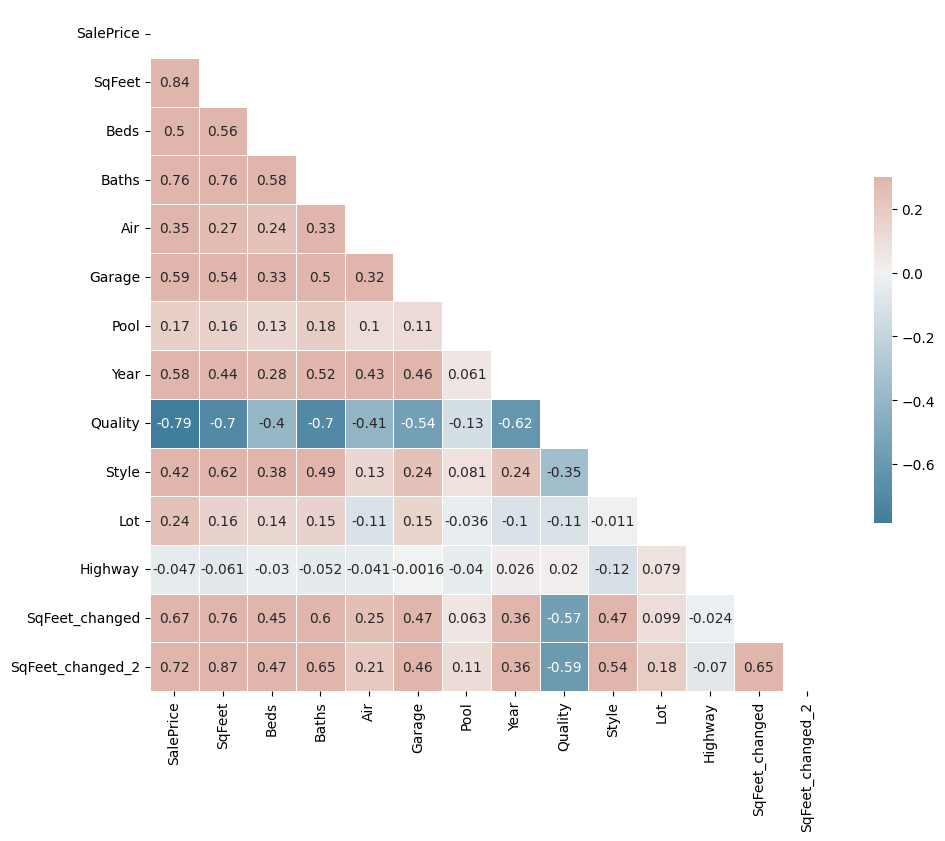

In [96]:
corrplot(data)

In [97]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet_changed_2", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.7002558187473717
Coefficients are: [ 0.01570594 -0.01595838  0.51608347]


In [98]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.6996730222588954
Coefficients are: [0.01624071 0.49614463]


Как видно, только один признак имеет большой вес, точность при этом практически не меняется. Однако значимость многих признаков становится неудовлетворительной. Поэтому, если оценить значимость коэффициентов модели, можно обнаружить, что многие признаки просто не нужны. При этом получается, что даже при очень небольшом изменении модели мы можем сделать совершенно противоположные выводы о том, какие признаки важны.

Итак, первый способ найти коллинеарные признаки - оценить значимость коэффициентов (t-statistic + p-value)

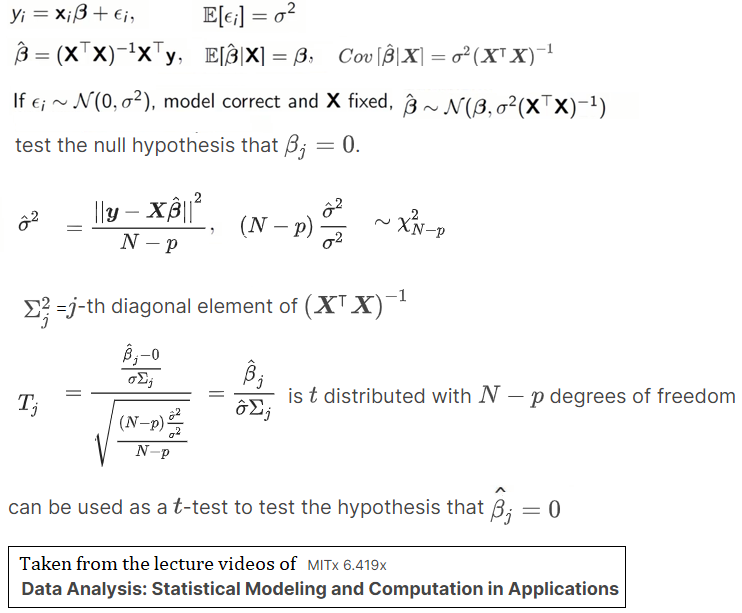

In [99]:
from scipy.stats import t

In [100]:
def get_p_values(model, x: pd.DataFrame, y: pd.DataFrame, a: int = 0.01) -> None:
  beta_hat = [model.intercept_] + model.coef_.tolist()
  n = len(x)
  print(f"Coeffficents: {beta_hat}")
  x_1 = np.column_stack((np.ones(n), x))
  # standard deviation of the noise.
  sigma_hat = np.sqrt(np.sum(np.square(y - x_1@beta_hat)) / (n - x_1.shape[1]))
  # estimate the covariance matrix for beta
  beta_cov = np.linalg.inv(x_1.T@x_1)
  # the t-test statistic for each variable from the formula from above figure
  t_vals = beta_hat / (sigma_hat * np.sqrt(np.diagonal(beta_cov)))
  # compute 2-sided p-values.
  p_vals = t.sf(np.abs(t_vals), n-x_1.shape[1])*2
  print(f"T values: {t_vals}")
  print(f"p-values: {p_vals}")
  print(f"Is valuable: {p_vals > 0.01}")

In [101]:
get_p_values(model, x_test, y_test)

Coeffficents: [4.674327752645325, 0.016240711006736838, 0.49614462783103386]
T values: [ 5.20692464  0.34198828 10.77166934]
p-values: [7.44365272e-07 7.32920571e-01 1.17629062e-19]
Is valuable: [False  True False]


Мультиколлинеарность можно обнаружить и с помощью коэффициента инфляции дисперсии (VIF). Для каждого признака в построенной модели этот коэффициент покащзывает, в какой степени коэфициент "испорчен" коллинеарностью с другими признаками.

В методе VIF мы выбираем каждый признак и сравниваем его со всеми другими признаками. Для каждого признака коэффициент рассчитывается как:

image.png
где R-квадрат — коэффициент детерминации в линейной регрессии этого признака, построенной по всем остальным признакам (1-to-all). Его значение лежит между 0 и 1.
Как мы видим из формулы, чем больше значение R-квадрат, тем больше VIF. Следовательно, больший VIF означает большую корреляцию. Это согласуется с тем фактом, что более высокое значение R-квадрат означает более сильную коллинеарность. Обычно значение VIF выше 5 указывает на высокую мультиколлинеарность.


In [103]:
!pip install statsmodels

  Using cached statsmodels-0.14.1-cp310-cp310-win_amd64.whl.metadata (9.8 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
Using cached statsmodels-0.14.1-cp310-cp310-win_amd64.whl (9.8 MB)
Using cached patsy-0.5.6-py2.py3-none-any.whl (233 kB)


In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i)
                          for i in range(len(x_train.columns))]

print(vif_data)

          feature       VIF
0  SqFeet_changed  9.446442
1          SqFeet  9.446442


Как мы видим, наши переменные имеют очень высокие значения VIF, что означает сильную коллинеарность между ними.


In [105]:
features = ['SqFeet', 'Beds', 'Baths', 'Air', 'Garage', 'Pool', 'Year',
       'Quality', 'Style', 'Lot', 'Highway']

In [106]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[features], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.8333627167756659
Coefficients are: [ 0.32128686  0.01746661  0.05093416  0.00689765  0.03780231  0.03515141
  0.0033515  -0.11809948 -0.01708504  0.00487232 -0.06529713]


In [107]:
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i)
                          for i in range(len(x_train.columns))]
vif_data

,feature,VIF
0,SqFeet,44.314842
1,Beds,21.771159
2,Baths,21.310745
3,Air,7.332373
4,Garage,17.244375
5,Pool,1.114873
6,Year,121.269750
7,Quality,33.782352
8,Style,4.639236
9,Lot,5.769237


Теперь можно удалить некоторые признаки. Для этого используются разные способы feature selection. Посмотрим, узменится ли предсказание при удалении некоторых признаков

In [108]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(
    data[['SqFeet', 'Air', 'Garage', 'Pool', 'Year',
       'Quality', 'Style', 'Lot', 'Highway']],
    data["SalePrice"],
    random_state=42
    )
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.8472695564198964
Coefficients are: [ 0.36415586  0.01433265  0.0430225   0.04483949  0.00386258 -0.13999628
 -0.01449323  0.00511473 -0.07667206]


In [109]:
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i)
                          for i in range(len(x_train.columns))]
vif_data

,feature,VIF
0,SqFeet,36.861607
1,Air,7.249785
2,Garage,17.094127
3,Pool,1.111306
4,Year,109.473993
5,Quality,29.253419
6,Style,4.535784
7,Lot,5.765015
8,Highway,1.059443
